In [2]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import mallet as mal
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [3]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt']

In [4]:
path_csv = "corpus_csv"

doclist_csv = pre.create_document_list(path_csv, 'csv')
doclist_csv[:5]

INFO preprocessing: Creating document list from CSV files ...


['corpus_csv/Doyle_AScandalinBohemia.txt.csv',
 'corpus_csv/Doyle_AStudyinScarlet.txt.csv',
 'corpus_csv/Doyle_TheHoundoftheBaskervilles.txt.csv',
 'corpus_csv/Doyle_TheSignoftheFour.txt.csv',
 'corpus_csv/Howard_GodsoftheNorth.txt.csv']

In [5]:
path_tei = "corpus_tei"

doclist_tei = pre.create_document_list(path_tei, 'xml')
doclist_tei[:5]

INFO preprocessing: Creating document list from XML files ...


['corpus_tei/Schnitzler_Amerika.xml',
 'corpus_tei/Schnitzler_DerAndere.xml',
 'corpus_tei/Schnitzler_DerWitwer.xml',
 'corpus_tei/Schnitzler_DieFremde.xml',
 'corpus_tei/Schnitzler_GeschichteeinesGenies.xml']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [6]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [7]:
corpus_txt = pre.read_from_txt(doclist_txt)

In [8]:
corpus_csv = pre.read_from_csv(doclist_csv)

In [9]:
corpus_tei = pre.read_from_tei(doclist_tei)

#### Tokenisieren

In [10]:
doc_tokens = pre.filter_pos_tags(list(corpus_csv)[0])
list(doc_tokens)[0][:5]

INFO preprocessing: Accessing CSV documents ...
INFO preprocessing: Accessing ['ADJ', 'V', 'NN'] ...


12       be
14    _the_
15    woman
18     have
20     hear
Name: Lemma, dtype: object

In [11]:
doc_tokens = [list(pre.tokenize(tei)) for tei in list(corpus_tei)]
doc_tokens[0][:5]

INFO preprocessing: Accessing TEI XML documents ...


['arthur', 'schnitzler', 'amerika', 'das', 'schiff']

In [12]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]
doc_tokens[0][:5]

INFO preprocessing: Accessing TXT documents ...


['scandal', 'in', 'bohemia', 'conan', 'doyle']

#### Create Dictionaries

In [13]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [14]:
sparse_bow = pre.create_sparse_matrix(doc_labels, doc_tokens, id_types, doc_ids)

In [15]:
sparse_bow[:5]

0
doc_id token_id    
1      16384     13
       3          1
       16388     19
       17750      1
       960        1

#### Convert to Doc-Topic Matrix

'''import pandas as pd

doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

cols = [doc2id[key] for key in set(sparse_bow.index.get_level_values("doc_id"))]
#idx = [type2id[key] for key in set(sparse_bow.index.get_level_values("token_id"))]

set(sparse_bow.index.get_level_values("token_id"))

#doctopic_matrix = pd.DataFrame(columns=cols, index=idx)'''

#### Remove Features

In [16]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [17]:
sparse_df_stopwords_removed = pre.remove_features(sparse_bow, id_types, stopword_list)

INFO preprocessing: Removing features ...


In [18]:
print(len(sparse_bow))
print(len(sparse_df_stopwords_removed))

56639
51019


##### Create Feature Remove Lists

In [19]:
stopword_list = pre.find_stopwords(sparse_bow, id_types, 100)
len(stopword_list)

INFO preprocessing: Finding stopwords ...


100

In [20]:
hapax_list = pre.find_hapax(sparse_bow, id_types)
len(hapax_list)

INFO preprocessing: Find hapax legomena ...


9787

##### Remove Features

In [21]:
feature_list = set(stopword_list).union(hapax_list)
clean_term_frequency = pre.remove_features(sparse_bow, id_types, feature_list)

INFO preprocessing: Removing features ...


In [22]:
len(clean_term_frequency)

45200

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [23]:
#num_docs = max(sparse_bow.index.get_level_values("doc_id"))
#num_types = max(sparse_bow.index.get_level_values("token_id"))
#sum_counts = sum(sparse_bow[0])

#header_string = str(num_docs) + " " + str(num_types) + " " + str(sum_counts) + "\n"

#with open("gb_plain.mm", 'w', encoding = "utf-8") as f:
#    pass

#with open("gb_plain.mm", 'a', encoding = "utf-8") as f:
#    f.write("%%MatrixMarket matrix coordinate real general\n")
#    f.write(header_string)
#    sparse_bow.to_csv( f, sep = ' ', header = None)

pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [24]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [25]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [26]:
#in case you're only loading the corpus - build dict first

#import pickle

#pickle.dump( id_types, open( "gb_plain.dictionary", "wb" ) )

In [27]:
#id_types = pickle.load(open("gb_plain.dictionary", 'rb'))

In [28]:
#mm = gensim.corpora.MmCorpus("gb_all.mm")

In [29]:
#id_types = pickle.load(open("gb_all.dictionary", 'rb'))

In [30]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

In [31]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=10)

INFO gensim.models.ldamodel: using symmetric alpha at 0.1
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 10 topics, 1 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 50x with a convergence threshold of 0.001000
WARNING gensim.models.ldamodel: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO gensim.models.ldamodel: -11.192 per-word bound, 2339.6 perplexity estimate based on a held-out corpus of 17 documents with 369906 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #2 (0.100): 0.058*"anecdote" + 0.035*"skulk" + 0.030*"homecoming" + 0.025*"phew" + 0.017*"quibblers" + 0.016*"spawn" + 0.014*"parentage" + 0.014*"fana

In [32]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['anecdote',
 'skulk',
 'parentage',
 'phew',
 'fanatics',
 'homecoming',
 'spawn',
 'faintest',
 'diaphanous',
 'quibblers']

In [33]:
#Anzeige der id des ersten keywords aus dem topic
'''n = 0
for key, value in type2id.items():
    if value == topicTerms[n]:
        print(key)'''

'n = 0\nfor key, value in type2id.items():\n    if value == topicTerms[n]:\n        print(key)'

In [34]:
#Gensim-Funktion -> Anzeige des word_id-probability-mappings eines topics n
'''n = 0
topicN = model.get_topic_terms(n)
topicN'''

'n = 0\ntopicN = model.get_topic_terms(n)\ntopicN'

In [35]:
#Topic probabilities
topics = model.show_topics(num_topics = 10)
topics[:2]

[(0,
  '0.054*"anecdote" + 0.033*"skulk" + 0.026*"phew" + 0.026*"homecoming" + 0.014*"disarm" + 0.013*"parentage" + 0.013*"gesticulation" + 0.012*"quibblers" + 0.009*"fanatics" + 0.009*"spawn"'),
 (1,
  '0.050*"anecdote" + 0.038*"skulk" + 0.022*"parentage" + 0.020*"phew" + 0.017*"fanatics" + 0.013*"homecoming" + 0.012*"spawn" + 0.011*"faintest" + 0.008*"diaphanous" + 0.008*"quibblers"')]

from scipy.io import mmread
test = mmread("gb_plain.mm")
import pandas as pd
pd.DataFrame(test.data)

## Visualisierung 

In [36]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [37]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

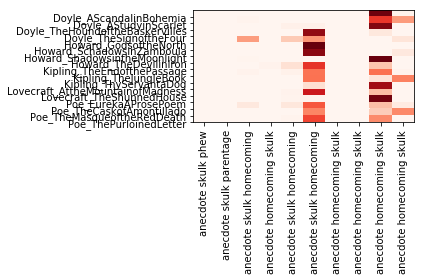

In [38]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

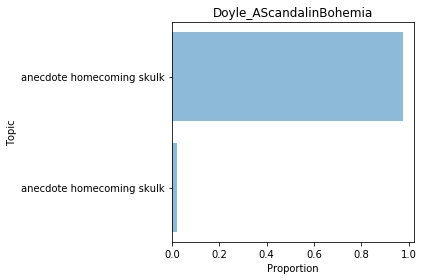

In [39]:
visual.plot_doc_topics(doc_topic, 0)

#### Heatmap

In [40]:
#heatmap = visual.make_heatmap()

In [41]:
#visual.save_heatmap("./visualizations/heatmap")

#### Interactive

In [42]:
#vis = collection.Visualization(lda_model, corpus, dictionary, doc_labels, interactive=True)

In [43]:
#vis.make_interactive()

In [44]:
#vis.save_interactive("./visualizations/interactive")

## Evaluation

In [45]:
segmented_topics = evaluation.topic_segmenter(model, type2id, 10)
segmented_topics[0][:5]

[('anecdote', 'skulk'),
 ('anecdote', 'phew'),
 ('anecdote', 'homecoming'),
 ('anecdote', 'disarm'),
 ('anecdote', 'parentage')]

In [46]:
umass_probability = evaluation.token_probability(doc_tokens, segmented_topics)
umass_probability

faintest         {9, 13}
parentage           {13}
know-quite          {10}
disarm               {1}
gesticulation       {14}
fanatics             {3}
vision's            {11}
skulk                {5}
diaphanous           {3}
cooped               {1}
fête                {15}
phew              {8, 9}
spawn               {11}
anecdote             {3}
homecoming          {11}
quibblers           {13}
dtype: object

In [47]:
umass = evaluation.calculate_umass(segmented_topics, umass_probability, doc_tokens, 10)
umass

0.04455572793661132

In [48]:
wiki_list = evaluation.wikipedia_table_crawler()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bs4/builder/_lxml.py:250: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  self.parser.feed(markup)


In [49]:
wiki_corpus = evaluation.wikipedia_crawler(wiki_list, size=5)

In [50]:
uci_probability = evaluation.token_probability(wiki_corpus, segmented_topics)

In [51]:
pmi = evaluation.calculate_pointwise_mutual_information(segmented_topics, wiki_corpus, uci_probability)

In [52]:
uci = evaluation.calculate_uci(pmi, wiki_corpus, 10)
uci

0.0

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)